# Getting Data

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import config

In [ ]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=config.client_id, client_secret=config.client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
playlistNames = ['Chill Car - Rap', 'Bollywood Beats', 'Lit Songs', 'Chill - Pop', 'Epic Vibes', 'Nostalgic EDM'] 
playlist_links = ["https://open.spotify.com/playlist/39yrrZvXXVTQjnv41mLZE5?si=043d2b062b4748c7",
                  "https://open.spotify.com/playlist/12p5ArAxY6r3QOtNATi7Mx?si=0e44c2c5c12d4f45",
                  "https://open.spotify.com/playlist/4KhumTd9QyJM3RUvAzSJh7?si=edc7bcc04f1c43a9",
                  "https://open.spotify.com/playlist/2W4rSltujQSUyXT3Yu03ga?si=7ff0dd18a47b4517",
                  "https://open.spotify.com/playlist/2K1GpNap0DQs2BsTwbGGPI?si=bcea1ac135924f04",
                  "https://open.spotify.com/playlist/0KAbqWJrRxqhaoYKVu2hDE?si=0ebdb168c8634f40"
                ]
playlist_URIs = [playlist_link.split("/")[-1].split("?")[0] for playlist_link in playlist_links]

In [ ]:
def get_playlist_tracks(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [ ]:
def get_data():
    song_data = []
    seen_songs = set()
    for index, playlist_URI in enumerate(playlist_URIs):
        print(playlistNames[index])
        tracks = get_playlist_tracks(playlist_URI)
        for track in tracks:
            # URI
            track_uri = track["track"]["uri"]
            
            # Skip duplicate songs
            if track_uri in seen_songs:
                continue
            
            # Add song URI to seen_songs set
            seen_songs.add(track_uri)
            
            # Track name
            track_name = track["track"]["name"]
            # Main Artist
            artists = []
            artist_genres = set()
            
            for artist in track["track"]["artists"]:
                artist_uri = artist["uri"]
                artist_info = sp.artist(artist_uri)
                artists.append(artist['name'])
                artist_genres.update(artist_info["genres"])

            # Album
            album = track["track"]["album"]["name"]
            
            # release date
            release_date = track["track"]["album"]["release_date"][0:4]

            # Popularity of the track
            track_pop = track["track"]["popularity"]
            
            # Audio Features
            audio_features = sp.audio_features(track_uri)[0]
            selected_features = {
                'danceability': audio_features['danceability'],
                'energy': audio_features['energy'],
                'key': audio_features['key'],
                'loudness': audio_features['loudness'],
                'speechiness': audio_features['speechiness'],
                'acousticness': audio_features['acousticness'],
                'instrumentalness': audio_features['instrumentalness'],
                'liveness': audio_features['liveness'],
                'valence': audio_features['valence'],
                'tempo': audio_features['tempo']
            }
            
            song_data.append([track_name, artists, list(artist_genres), track_pop, release_date] + list(selected_features.values()) + [playlistNames[index]])

    # Create the dataframe
    columns = ['Track Name', 'Artist Name', 'Artist Genres', 'Track Popularity', 'Release Date'] + list(selected_features.keys()) + ['Playlist Name']
    df = pd.DataFrame(song_data, columns=columns)
    df.to_pickle('songData')

    return df

#df = get_data() 

In [ ]:
df = pd.read_pickle('songData')
df 

# Exploring Data

In [ ]:
import matplotlib.pyplot as plt

genre_freq = {}

for genre_list in df['Artist Genres']:
    for g in genre_list:
        if g in genre_freq:
            genre_freq[g] += 1
        else:
            genre_freq[g] = 1

sorted_data = dict(sorted(genre_freq.items(), key=lambda x: x[1]))

genre_freq_filtered = {genre: frequency for genre, frequency in sorted_data.items() if frequency > 15}

plt.bar(genre_freq_filtered.keys(), genre_freq_filtered.values(), color='g')

# Set labels and title
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Most Common Music Genres')

# Rotate the genre labels for better visibility
plt.xticks(rotation=90)

# Display the histogram
plt.show()

In [ ]:
import re

artist_freq = {}

# Filter out artists' names with special characters
pattern = re.compile(r'^[a-zA-Z0-9\s]+$')  # Regular expression pattern to match alphanumeric characters and spaces

for artists in df['Artist Name']:
    for artist in artists:
        if re.match(pattern, artist):
            if artist in artist_freq:
                artist_freq[artist] += 1
            else:
                artist_freq[artist] = 1


sorted_data = dict(sorted(artist_freq.items(), key=lambda x: x[1]))

genre_freq_filtered = {genre: frequency for genre, frequency in sorted_data.items() if frequency > 7}

plt.bar(genre_freq_filtered.keys(), genre_freq_filtered.values(), color='g')

# Set labels and title
plt.xlabel('Artists')
plt.ylabel('Frequency')
plt.title('Most Common Music Artists')

# Rotate the genre labels for better visibility
plt.xticks(rotation=90)

# Display the histogram
plt.show()

# Processing

In [ ]:
def genre_encoding(df):
    df['Rap Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['drill', 'rap', 'hip hop']), ' '.join(x)) else 0)
    df['Pop Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['pop', 'dance', 'broadway', 'reggae fusion']), ' '.join(x)) else 0)
    df['Rock Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['rock', 'metalcore']), ' '.join(x)) else 0)
    df['R&B Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['r&b', 'blues', 'rhythm', 'dixieland', 'harlem']), ' '.join(x)) else 0)
    df['Bollywood Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['filmi', 'bollywood', 'indian', 'mollywood']), ' '.join(x)) else 0)
    df['EDM Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['edm', 'electro', 'nordic house', 'speedrun', 'gaming edm', 'dubstep', 'brostep']), ' '.join(x)) else 0)
    df['Soundtrack Genre'] = df['Artist Genres'].apply(lambda x: 1 if re.search('|'.join(['orchestra', 'soundtrack', 'movie', 'hollywood', 'anime lo-fi']), ' '.join(x)) else 0)
genre_encoding(df)

In [ ]:
# Tracks with genres but unlisted from above
df.loc[(df.iloc[:, 16:].sum(axis=1) == 0) & (df['Artist Genres'].map(len) != 0)]

In [ ]:
df['Release Date'] = pd. to_numeric(df['Release Date'])

# Normalizing + Handling Categoricals

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

x = df.iloc[:, 3:].drop("Playlist Name", axis=1).values
scaler = StandardScaler()
X = scaler.fit_transform(x) # normalizing the features

y = df[['Playlist Name']]
ohe = OneHotEncoder()
Y_ohe = ohe.fit_transform(y)
Y = Y_ohe.toarray()

print(Y[0],'\n', ohe.categories_)

# Visualize

In [ ]:
from sklearn.decomposition import PCA
pca_song = PCA(n_components=2)
principalComponents_songs = pca_song.fit_transform(X)

principal_song_df = pd.DataFrame(data = principalComponents_songs)

label_encoder = pd.factorize(df['Playlist Name'])
labels = label_encoder[0]

scatter = plt.scatter(principal_song_df[0], principal_song_df[1], c=labels)

# Add labels and title to the plot
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Scatter Plot')
plt.legend(scatter.legend_elements()[0], playlistNames, title='Playlist URI')

In [ ]:
import plotly.graph_objects as go

pca_song = PCA(n_components=3)
principalComponents_songs = pca_song.fit_transform(X)

principal_song_df = pd.DataFrame(data = principalComponents_songs)

label_encoder = pd.factorize(df['Playlist Name'])
labels = label_encoder[0]

# Create a trace for the scatter plot
trace = go.Scatter3d(
    x=principal_song_df[0],
    y=principal_song_df[1],
    z=principal_song_df[2],  # Assuming you have three components in your PCA data
    mode='markers',
    marker=dict(
        size=5,
        color=labels,
        colorscale='Viridis',  # You can choose any colorscale you prefer
        colorbar=dict(
            title='Playlist URI'
        )
    )
)

# Create the layout for the 3D plot
layout = go.Layout(
    title='PCA 3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='Component 1'),
        yaxis=dict(title='Component 2'),
        zaxis=dict(title='Component 3')  # Assuming you have three components in your PCA data
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the interactive plot
fig.show()

No Genre Information Given

In [ ]:
x_nogenre = df.iloc[:, 3:].drop("Playlist Name", axis=1).iloc[:, :-7].values
X_nogenre = StandardScaler().fit_transform(x_nogenre)
pca_song = PCA(n_components=2)
principalComponents_songs = pca_song.fit_transform(X_nogenre)

principal_song_df = pd.DataFrame(data = principalComponents_songs)

label_encoder = pd.factorize(df['Playlist Name'])
labels = label_encoder[0]

scatter = plt.scatter(principal_song_df[0], principal_song_df[1], c=labels)

# Add labels and title to the plot
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Scatter Plot')
plt.legend(scatter.legend_elements()[0], playlistNames, title='Playlist URI')

# NN to sort songs

NN with Genre Information Given

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state = 0)

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dropout
 
model = Sequential()
model.add(Dense(256, input_dim=X.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.001))) 
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.001)))  
model.add(Dropout(0.4))
model.add(Dense(Y.shape[1], activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0, epochs=50, batch_size=16)

In [ ]:
plt.plot(hist.history['accuracy'], label='Acc')
plt.plot(hist.history['val_accuracy'], label='Val Acc')
plt.title('Acc Over Epochs')
plt.ylabel('Acc')
plt.xlabel('No. epoch')
plt.show()

5/5 [==============================] - 0s 2ms/step


Text(113.9222222222222, 0.5, 'Actual label')

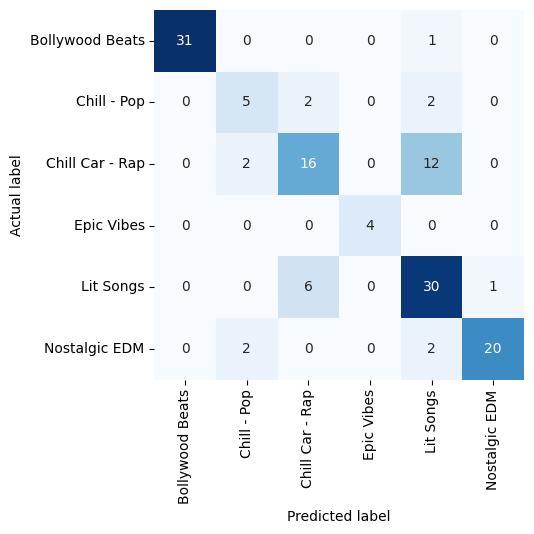

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
 
y_predicted = model.predict(X_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=ohe.categories_[0],
            yticklabels=ohe.categories_[0])
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# Examing Data After Findings

In [ ]:
chill = df.loc[df["Playlist Name"] == "Chill Car - Rap"]
lit = df.loc[df["Playlist Name"] == "Lit Songs"]

In [ ]:
chill.columns

In [ ]:
import numpy as np

columns_to_compare = ['Track Popularity',
       'Release Date', 'danceability', 'energy', 'key', 'loudness']
    #    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    #    'valence', 'tempo']

num_cols = 3  # Number of columns in the grid
num_rows = (len(columns_to_compare) - 1) // num_cols + 1  # Number of rows in the grid

# Create the grid plot for histograms
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Iterate over the columns and create histograms in the grid plot
for i, col in enumerate(columns_to_compare):
    ax = axes[i // num_cols, i % num_cols]  # Get the appropriate axis from the grid layout

    # Compute histogram values and bin edges for each dataframe
    hist1, bins1 = np.histogram(chill[col], bins='auto', density=True)
    hist2, bins2 = np.histogram(lit[col], bins='auto', density=True)
    
    # Compute the bin width
    bin_width = bins1[1] - bins1[0]
    
    # Plot histogram for dataframe 1
    ax.bar(bins1[:-1], hist1, width=bin_width, alpha=0.5, label='Chill')
    
    # Plot histogram for dataframe 2
    ax.bar(bins2[:-1], hist2, width=bin_width, alpha=0.5, label='Lit')
    
    ax.set_xlabel(col)  # Set the x-axis label
    ax.set_ylabel('Density')  # Set the y-axis label as Density
    ax.legend()  # Show the legend

# Remove empty subplots if there are any
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

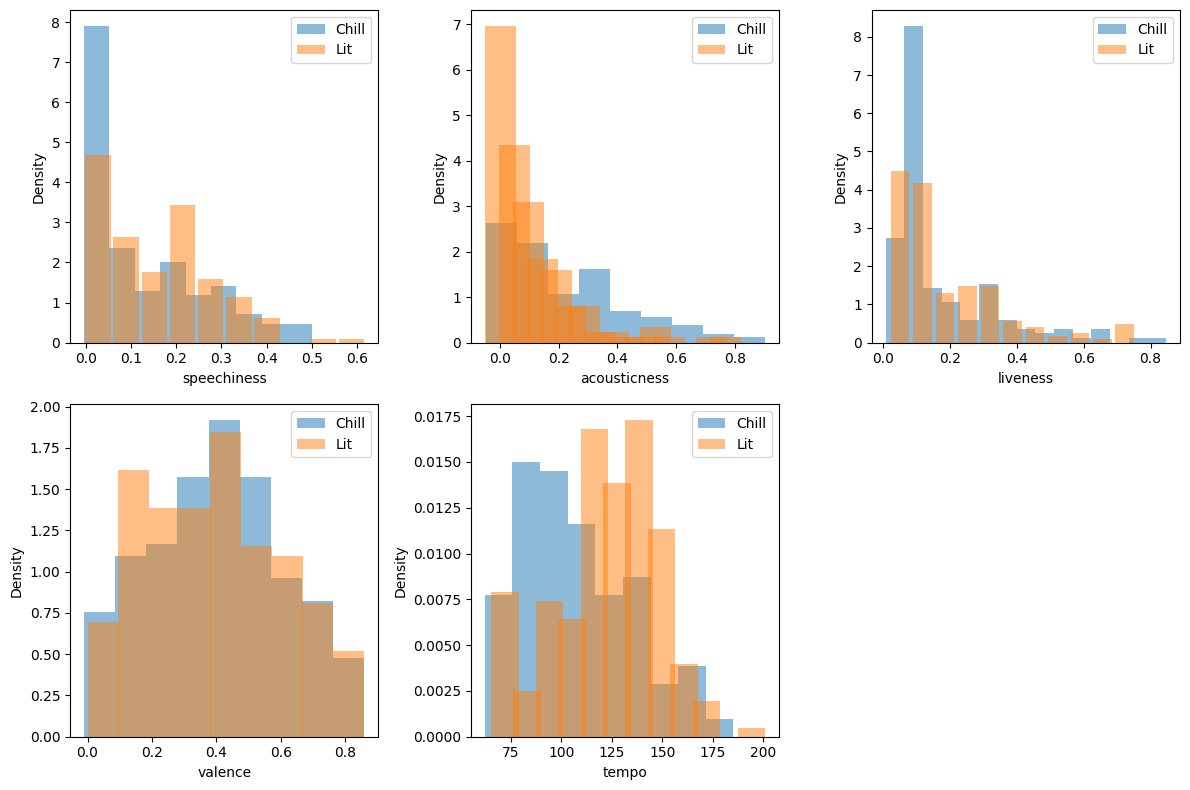

In [31]:
import numpy as np

columns_to_compare = ['speechiness', 'acousticness', 'liveness',
       'valence', 'tempo']

num_cols = 3  # Number of columns in the grid
num_rows = (len(columns_to_compare) - 1) // num_cols + 1  # Number of rows in the grid

# Create the grid plot for histograms
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Iterate over the columns and create histograms in the grid plot
for i, col in enumerate(columns_to_compare):
    ax = axes[i // num_cols, i % num_cols]  # Get the appropriate axis from the grid layout

    # Compute histogram values and bin edges for each dataframe
    hist1, bins1 = np.histogram(chill[col], bins='auto', density=True)
    hist2, bins2 = np.histogram(lit[col], bins='auto', density=True)
    
    # Compute the bin width
    bin_width = bins1[1] - bins1[0]
    
    # Plot histogram for dataframe 1
    ax.bar(bins1[:-1], hist1, width=bin_width, alpha=0.5, label='Chill')
    
    # Plot histogram for dataframe 2
    ax.bar(bins2[:-1], hist2, width=bin_width, alpha=0.5, label='Lit')
    
    ax.set_xlabel(col)  # Set the x-axis label
    ax.set_ylabel('Density')  # Set the y-axis label as Density
    ax.legend()  # Show the legend

# Remove empty subplots if there are any
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Unsupervised Classification